In [103]:
import fastf1 as ff1
import pandas as pd
from fastf1 import plotting, utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from urllib.request import urlopen
import json
import requests
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error as MSE
import seaborn as sns
from scipy.stats.mstats import winsorize

In [134]:
results = pd.read_parquet('2024_fp3_results.parquet')
results['FP3BestLapTime'] = results['FP3BestLapTime'].dt.total_seconds()
best_fp3_times = results.groupby(["EventName", "RoundNumber"])[["FP3BestLapTime"]].min().rename(columns={"FP3BestLapTime": "FP3BestOverallLapTime"}).reset_index()
results = pd.merge(results, best_fp3_times, how="left", on=["EventName", "RoundNumber"])
results["FP3Delta"] = results["FP3BestLapTime"] - results["FP3BestOverallLapTime"]
results["FP3DeltaFrac"] = results["FP3Delta"] / results["FP3BestLapTime"]
results.columns

r2 = results.copy()
r2 = r2[['DriverNumber', 'RoundNumber', 'GridPosition']]
r2['RoundNumber'] = r2['RoundNumber'] + 1
r2['PrevQualiPosition'] = r2['GridPosition']
r2 = r2[['DriverNumber', 'RoundNumber', 'PrevQualiPosition']]
results = pd.merge(results, r2, on=['DriverNumber', 'RoundNumber'])
results.columns

Index(['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName',
       'TeamColor', 'TeamId', 'FirstName', 'LastName', 'FullName',
       'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
       'GridPosition', 'Q1', 'Q2', 'Q3', 'Time', 'Status', 'Points',
       'RoundNumber', 'Country', 'EventName', 'QualifyingPosition',
       'FP3BestLapTime', 'FP3BestOverallLapTime', 'FP3Delta', 'FP3DeltaFrac',
       'PrevQualiPosition'],
      dtype='object')

0.4521259530628015


<Axes: xlabel='FP3Delta', ylabel='GridPosition'>

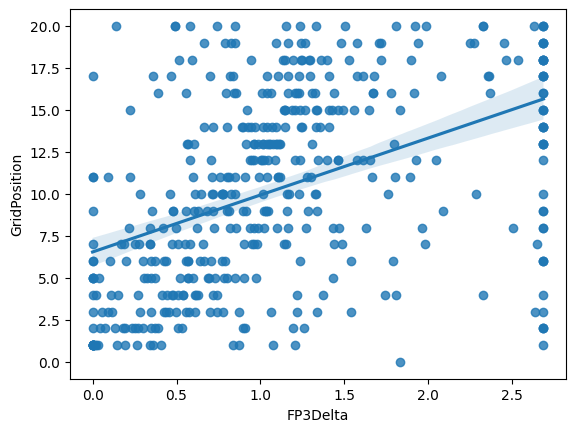

In [135]:
results['FP3Delta'] = winsorize(results['FP3Delta'], limits=(0, 0.1))
corr = results['FP3Delta'].corr(results['GridPosition'])
print(corr)
sns.regplot(data=results, x='FP3Delta', y ='GridPosition')

In [137]:
X = results[['FP3Delta', 'PrevQualiPosition']]
y = results['GridPosition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2 = MSE(y_test, y_pred)** 0.5
print(r2)

3.838264440166504


<Axes: ylabel='GridPosition'>

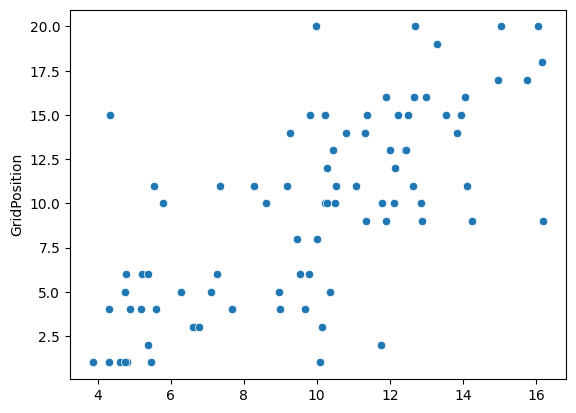

In [138]:
sns.scatterplot(x=y_pred, y=y_test)